# DPG for Cartpole


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [6]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.4807425729704105 -2.8180765092660307
actions: 1 0
rewards: 1.0 1.0


In [7]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [8]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [9]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [10]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [11]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [12]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [13]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # targetQs/nextQs
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True) # Qs
    rates = tf.reshape(rates, shape=[-1, 1])
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [14]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [15]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [16]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [17]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [18]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [19]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [20]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [21]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, _ = sess.run([model.d_lossA, model.d_optA],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            dlossQ, _ = sess.run([model.d_lossQ, model.d_optQ],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt],
                                  feed_dict = {model.states: states, 
                                               model.actions: actions,
                                               model.targetQs: targetQs, 
                                               model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:25.0000 R:25.0000 rate:0.0500 gloss:0.8496 dlossA:0.8921 dlossQ:0.8805 exploreP:0.9975
Episode:1 meanR:22.5000 R:20.0000 rate:0.0400 gloss:0.8418 dlossA:0.9542 dlossQ:0.8937 exploreP:0.9956
Episode:2 meanR:23.6667 R:26.0000 rate:0.0520 gloss:0.8669 dlossA:0.9081 dlossQ:0.8561 exploreP:0.9930
Episode:3 meanR:25.5000 R:31.0000 rate:0.0620 gloss:0.7936 dlossA:0.8489 dlossQ:0.8087 exploreP:0.9900
Episode:4 meanR:25.0000 R:23.0000 rate:0.0460 gloss:0.8268 dlossA:0.8671 dlossQ:0.8889 exploreP:0.9877
Episode:5 meanR:25.3333 R:27.0000 rate:0.0540 gloss:0.8296 dlossA:0.8865 dlossQ:0.8504 exploreP:0.9851
Episode:6 meanR:24.2857 R:18.0000 rate:0.0360 gloss:0.8729 dlossA:0.9236 dlossQ:0.8491 exploreP:0.9833
Episode:7 meanR:22.8750 R:13.0000 rate:0.0260 gloss:0.9105 dlossA:0.9625 dlossQ:1.0276 exploreP:0.9820
Episode:8 meanR:21.4444 R:10.0000 rate:0.0200 gloss:0.7552 dlossA:0.8171 dlossQ:0.7927 exploreP:0.9811
Episode:9 meanR:20.2000 R:9.0000 rate:0.0180 gloss:0.8980 dlossA:0.9263 d

Episode:79 meanR:25.5875 R:30.0000 rate:0.0600 gloss:0.8415 dlossA:0.8635 dlossQ:0.9180 exploreP:0.8167
Episode:80 meanR:25.4198 R:12.0000 rate:0.0240 gloss:0.8112 dlossA:0.8436 dlossQ:0.9076 exploreP:0.8158
Episode:81 meanR:25.3171 R:17.0000 rate:0.0340 gloss:0.8670 dlossA:0.9028 dlossQ:0.9105 exploreP:0.8144
Episode:82 meanR:25.5422 R:44.0000 rate:0.0880 gloss:0.8625 dlossA:0.8896 dlossQ:0.9143 exploreP:0.8109
Episode:83 meanR:25.6429 R:34.0000 rate:0.0680 gloss:0.8499 dlossA:0.8729 dlossQ:0.9417 exploreP:0.8082
Episode:84 meanR:25.6118 R:23.0000 rate:0.0460 gloss:0.8661 dlossA:0.8940 dlossQ:0.9114 exploreP:0.8063
Episode:85 meanR:25.7558 R:38.0000 rate:0.0760 gloss:0.8761 dlossA:0.8971 dlossQ:0.9337 exploreP:0.8033
Episode:86 meanR:25.7471 R:25.0000 rate:0.0500 gloss:0.8863 dlossA:0.9127 dlossQ:0.9381 exploreP:0.8013
Episode:87 meanR:25.8750 R:37.0000 rate:0.0740 gloss:0.8114 dlossA:0.8419 dlossQ:0.9034 exploreP:0.7984
Episode:88 meanR:25.7978 R:19.0000 rate:0.0380 gloss:0.8176 dlos

Episode:158 meanR:33.8800 R:40.0000 rate:0.0800 gloss:0.8779 dlossA:0.8895 dlossQ:0.9376 exploreP:0.6222
Episode:159 meanR:34.3500 R:64.0000 rate:0.1280 gloss:0.9013 dlossA:0.9237 dlossQ:0.9366 exploreP:0.6183
Episode:160 meanR:34.2600 R:20.0000 rate:0.0400 gloss:0.9028 dlossA:0.9505 dlossQ:0.8794 exploreP:0.6171
Episode:161 meanR:34.0000 R:47.0000 rate:0.0940 gloss:0.8841 dlossA:0.8929 dlossQ:0.9616 exploreP:0.6143
Episode:162 meanR:34.4900 R:80.0000 rate:0.1600 gloss:0.8822 dlossA:0.9009 dlossQ:0.9363 exploreP:0.6094
Episode:163 meanR:34.3700 R:42.0000 rate:0.0840 gloss:0.8624 dlossA:0.8871 dlossQ:0.9031 exploreP:0.6069
Episode:164 meanR:34.8000 R:65.0000 rate:0.1300 gloss:0.8959 dlossA:0.9073 dlossQ:0.9248 exploreP:0.6031
Episode:165 meanR:34.5600 R:25.0000 rate:0.0500 gloss:0.8568 dlossA:0.8832 dlossQ:0.8986 exploreP:0.6016
Episode:166 meanR:34.5600 R:20.0000 rate:0.0400 gloss:0.8620 dlossA:0.8827 dlossQ:0.9063 exploreP:0.6004
Episode:167 meanR:34.5100 R:15.0000 rate:0.0300 gloss:0

Episode:236 meanR:53.2400 R:56.0000 rate:0.1120 gloss:0.8861 dlossA:0.8918 dlossQ:0.9204 exploreP:0.4032
Episode:237 meanR:53.6400 R:154.0000 rate:0.3080 gloss:0.9161 dlossA:0.9192 dlossQ:0.9120 exploreP:0.3972
Episode:238 meanR:53.5800 R:37.0000 rate:0.0740 gloss:0.9221 dlossA:0.9260 dlossQ:0.8944 exploreP:0.3958
Episode:239 meanR:54.0000 R:66.0000 rate:0.1320 gloss:0.8875 dlossA:0.8933 dlossQ:0.9085 exploreP:0.3933
Episode:240 meanR:54.4800 R:65.0000 rate:0.1300 gloss:0.8868 dlossA:0.8925 dlossQ:0.9150 exploreP:0.3908
Episode:241 meanR:54.2700 R:71.0000 rate:0.1420 gloss:0.9175 dlossA:0.9172 dlossQ:0.9068 exploreP:0.3881
Episode:242 meanR:54.4500 R:52.0000 rate:0.1040 gloss:0.9258 dlossA:0.9346 dlossQ:0.9203 exploreP:0.3861
Episode:243 meanR:54.8200 R:53.0000 rate:0.1060 gloss:0.9276 dlossA:0.9218 dlossQ:0.9189 exploreP:0.3841
Episode:244 meanR:55.0800 R:50.0000 rate:0.1000 gloss:0.8890 dlossA:0.9059 dlossQ:0.8870 exploreP:0.3823
Episode:245 meanR:55.4500 R:60.0000 rate:0.1200 gloss:

Episode:314 meanR:77.4100 R:75.0000 rate:0.1500 gloss:0.9668 dlossA:0.9510 dlossQ:0.9155 exploreP:0.2181
Episode:315 meanR:77.6800 R:88.0000 rate:0.1760 gloss:0.9684 dlossA:0.9532 dlossQ:0.9207 exploreP:0.2163
Episode:316 meanR:77.6200 R:48.0000 rate:0.0960 gloss:0.9783 dlossA:0.9616 dlossQ:0.9634 exploreP:0.2153
Episode:317 meanR:77.7600 R:62.0000 rate:0.1240 gloss:0.9678 dlossA:0.9388 dlossQ:0.9142 exploreP:0.2140
Episode:318 meanR:77.4700 R:66.0000 rate:0.1320 gloss:1.0017 dlossA:0.9815 dlossQ:0.9469 exploreP:0.2127
Episode:319 meanR:78.1500 R:101.0000 rate:0.2020 gloss:0.9797 dlossA:0.9561 dlossQ:0.9301 exploreP:0.2107
Episode:320 meanR:78.1800 R:42.0000 rate:0.0840 gloss:0.9556 dlossA:0.9284 dlossQ:0.9164 exploreP:0.2098
Episode:321 meanR:78.4000 R:59.0000 rate:0.1180 gloss:0.9865 dlossA:0.9683 dlossQ:0.8959 exploreP:0.2086
Episode:322 meanR:79.5900 R:152.0000 rate:0.3040 gloss:0.9650 dlossA:0.9488 dlossQ:0.9098 exploreP:0.2056
Episode:323 meanR:80.1600 R:101.0000 rate:0.2020 glos

Episode:393 meanR:110.4300 R:57.0000 rate:0.1140 gloss:1.0914 dlossA:1.0606 dlossQ:0.8640 exploreP:0.0926
Episode:394 meanR:110.8700 R:92.0000 rate:0.1840 gloss:1.0519 dlossA:1.0291 dlossQ:0.8813 exploreP:0.0919
Episode:395 meanR:111.6200 R:136.0000 rate:0.2720 gloss:1.0690 dlossA:1.0410 dlossQ:0.8470 exploreP:0.0908
Episode:396 meanR:113.0300 R:192.0000 rate:0.3840 gloss:1.1097 dlossA:1.0594 dlossQ:0.8891 exploreP:0.0892
Episode:397 meanR:112.5600 R:61.0000 rate:0.1220 gloss:1.1056 dlossA:1.0577 dlossQ:0.8810 exploreP:0.0888
Episode:398 meanR:112.8700 R:75.0000 rate:0.1500 gloss:1.1087 dlossA:1.0659 dlossQ:0.8941 exploreP:0.0882
Episode:399 meanR:112.9200 R:69.0000 rate:0.1380 gloss:1.0808 dlossA:1.0328 dlossQ:0.8728 exploreP:0.0876
Episode:400 meanR:114.2400 R:191.0000 rate:0.3820 gloss:1.1158 dlossA:1.0766 dlossQ:0.8867 exploreP:0.0862
Episode:401 meanR:114.6400 R:111.0000 rate:0.2220 gloss:1.1078 dlossA:1.0612 dlossQ:0.8698 exploreP:0.0853
Episode:402 meanR:113.4300 R:67.0000 rate:

Episode:471 meanR:126.4500 R:79.0000 rate:0.1580 gloss:1.3583 dlossA:1.3077 dlossQ:1.0016 exploreP:0.0429
Episode:472 meanR:126.7000 R:85.0000 rate:0.1700 gloss:1.3682 dlossA:1.3004 dlossQ:1.0175 exploreP:0.0426
Episode:473 meanR:126.9700 R:79.0000 rate:0.1580 gloss:1.3883 dlossA:1.2911 dlossQ:1.0042 exploreP:0.0424
Episode:474 meanR:127.5200 R:167.0000 rate:0.3340 gloss:1.3431 dlossA:1.2940 dlossQ:0.9911 exploreP:0.0418
Episode:475 meanR:127.6100 R:75.0000 rate:0.1500 gloss:1.3852 dlossA:1.2934 dlossQ:1.0953 exploreP:0.0416
Episode:476 meanR:124.9900 R:58.0000 rate:0.1160 gloss:1.3676 dlossA:1.2836 dlossQ:0.9900 exploreP:0.0414
Episode:477 meanR:126.4400 R:322.0000 rate:0.6440 gloss:1.3661 dlossA:1.2598 dlossQ:1.0122 exploreP:0.0404
Episode:478 meanR:123.1200 R:93.0000 rate:0.1860 gloss:1.3466 dlossA:1.2748 dlossQ:0.9651 exploreP:0.0401
Episode:479 meanR:126.0100 R:375.0000 rate:0.7500 gloss:1.3790 dlossA:1.2858 dlossQ:0.9971 exploreP:0.0390
Episode:480 meanR:125.8400 R:63.0000 rate:0

Episode:549 meanR:133.7000 R:101.0000 rate:0.2020 gloss:1.6826 dlossA:1.5344 dlossQ:1.2162 exploreP:0.0210
Episode:550 meanR:134.0600 R:105.0000 rate:0.2100 gloss:1.6792 dlossA:1.5841 dlossQ:1.0633 exploreP:0.0209
Episode:551 meanR:138.3800 R:500.0000 rate:1.0000 gloss:1.6422 dlossA:1.5646 dlossQ:1.0985 exploreP:0.0204
Episode:552 meanR:138.2600 R:72.0000 rate:0.1440 gloss:1.6135 dlossA:1.5128 dlossQ:1.1917 exploreP:0.0203
Episode:553 meanR:137.9300 R:63.0000 rate:0.1260 gloss:1.6227 dlossA:1.5656 dlossQ:1.1863 exploreP:0.0203
Episode:554 meanR:137.2100 R:63.0000 rate:0.1260 gloss:1.6655 dlossA:1.6002 dlossQ:1.2478 exploreP:0.0202
Episode:555 meanR:137.1400 R:76.0000 rate:0.1520 gloss:1.7186 dlossA:1.6154 dlossQ:1.1804 exploreP:0.0201
Episode:556 meanR:137.4100 R:97.0000 rate:0.1940 gloss:1.7785 dlossA:1.6049 dlossQ:1.1631 exploreP:0.0200
Episode:557 meanR:137.6700 R:114.0000 rate:0.2280 gloss:1.7234 dlossA:1.6992 dlossQ:1.0537 exploreP:0.0199
Episode:558 meanR:139.2800 R:312.0000 rate

Episode:627 meanR:175.1900 R:500.0000 rate:1.0000 gloss:2.0490 dlossA:2.0353 dlossQ:1.1297 exploreP:0.0127
Episode:628 meanR:175.5300 R:128.0000 rate:0.2560 gloss:2.0089 dlossA:2.0112 dlossQ:1.1079 exploreP:0.0127
Episode:629 meanR:179.3200 R:458.0000 rate:0.9160 gloss:nan dlossA:nan dlossQ:nan exploreP:0.0126
Episode:630 meanR:179.8900 R:152.0000 rate:0.3040 gloss:2.0014 dlossA:1.9629 dlossQ:1.0556 exploreP:0.0125
Episode:631 meanR:180.4200 R:111.0000 rate:0.2220 gloss:2.0356 dlossA:1.9137 dlossQ:1.1131 exploreP:0.0125
Episode:632 meanR:180.7300 R:87.0000 rate:0.1740 gloss:1.9012 dlossA:1.8583 dlossQ:1.0823 exploreP:0.0125
Episode:633 meanR:181.3200 R:129.0000 rate:0.2580 gloss:2.0719 dlossA:2.0442 dlossQ:1.2049 exploreP:0.0125
Episode:634 meanR:178.6700 R:204.0000 rate:0.4080 gloss:2.0361 dlossA:1.9704 dlossQ:1.0449 exploreP:0.0124
Episode:635 meanR:179.3800 R:157.0000 rate:0.3140 gloss:2.0073 dlossA:2.0542 dlossQ:1.1068 exploreP:0.0124
Episode:636 meanR:177.0200 R:201.0000 rate:0.40

Episode:705 meanR:156.9100 R:86.0000 rate:0.1720 gloss:2.2429 dlossA:2.3322 dlossQ:1.1978 exploreP:0.0109
Episode:706 meanR:156.6200 R:67.0000 rate:0.1340 gloss:2.3172 dlossA:2.3437 dlossQ:1.3886 exploreP:0.0109
Episode:707 meanR:157.4900 R:162.0000 rate:0.3240 gloss:2.2097 dlossA:2.3496 dlossQ:1.2275 exploreP:0.0109
Episode:708 meanR:158.3700 R:229.0000 rate:0.4580 gloss:2.2391 dlossA:2.3760 dlossQ:1.2225 exploreP:0.0108
Episode:709 meanR:153.9200 R:55.0000 rate:0.1100 gloss:2.1192 dlossA:2.1077 dlossQ:1.1043 exploreP:0.0108
Episode:710 meanR:155.0100 R:280.0000 rate:0.5600 gloss:nan dlossA:nan dlossQ:nan exploreP:0.0108
Episode:711 meanR:155.0700 R:135.0000 rate:0.2700 gloss:2.2228 dlossA:2.3519 dlossQ:1.4967 exploreP:0.0108
Episode:712 meanR:156.1800 R:314.0000 rate:0.6280 gloss:nan dlossA:nan dlossQ:nan exploreP:0.0108
Episode:713 meanR:152.5500 R:83.0000 rate:0.1660 gloss:2.1368 dlossA:2.0995 dlossQ:1.2343 exploreP:0.0108
Episode:714 meanR:152.4600 R:57.0000 rate:0.1140 gloss:2.20

Episode:783 meanR:141.5300 R:65.0000 rate:0.1300 gloss:2.2612 dlossA:2.4948 dlossQ:1.6868 exploreP:0.0103
Episode:784 meanR:142.8700 R:267.0000 rate:0.5340 gloss:2.1440 dlossA:2.4729 dlossQ:1.5593 exploreP:0.0103
Episode:785 meanR:143.6100 R:139.0000 rate:0.2780 gloss:2.0403 dlossA:2.4864 dlossQ:1.4637 exploreP:0.0103
Episode:786 meanR:143.1600 R:88.0000 rate:0.1760 gloss:2.1271 dlossA:2.4267 dlossQ:1.4789 exploreP:0.0103
Episode:787 meanR:141.1100 R:106.0000 rate:0.2120 gloss:2.3770 dlossA:2.6902 dlossQ:1.7629 exploreP:0.0103
Episode:788 meanR:140.9500 R:75.0000 rate:0.1500 gloss:2.2145 dlossA:2.4954 dlossQ:1.4109 exploreP:0.0103
Episode:789 meanR:141.5900 R:134.0000 rate:0.2680 gloss:2.1152 dlossA:2.5827 dlossQ:1.5850 exploreP:0.0103
Episode:790 meanR:141.6600 R:153.0000 rate:0.3060 gloss:2.4068 dlossA:2.7977 dlossQ:1.6746 exploreP:0.0103
Episode:791 meanR:140.7500 R:62.0000 rate:0.1240 gloss:2.2672 dlossA:2.5489 dlossQ:1.5085 exploreP:0.0103
Episode:792 meanR:138.7100 R:103.0000 rat

Episode:861 meanR:112.6100 R:136.0000 rate:0.2720 gloss:1.8830 dlossA:2.7369 dlossQ:1.4895 exploreP:0.0101
Episode:862 meanR:111.9900 R:88.0000 rate:0.1760 gloss:2.0656 dlossA:2.5440 dlossQ:1.5024 exploreP:0.0101
Episode:863 meanR:112.3300 R:91.0000 rate:0.1820 gloss:2.1163 dlossA:2.7815 dlossQ:1.4482 exploreP:0.0101
Episode:864 meanR:111.5500 R:73.0000 rate:0.1460 gloss:2.2960 dlossA:2.7963 dlossQ:1.4653 exploreP:0.0101
Episode:865 meanR:111.8400 R:107.0000 rate:0.2140 gloss:2.1865 dlossA:2.5483 dlossQ:1.8527 exploreP:0.0101
Episode:866 meanR:111.4200 R:98.0000 rate:0.1960 gloss:2.1514 dlossA:2.6862 dlossQ:1.8337 exploreP:0.0101
Episode:867 meanR:111.6600 R:84.0000 rate:0.1680 gloss:2.4591 dlossA:2.5952 dlossQ:2.2143 exploreP:0.0101
Episode:868 meanR:111.7500 R:94.0000 rate:0.1880 gloss:2.0506 dlossA:2.6811 dlossQ:1.4891 exploreP:0.0101
Episode:869 meanR:111.2300 R:77.0000 rate:0.1540 gloss:2.1351 dlossA:2.7432 dlossQ:1.6225 exploreP:0.0101
Episode:870 meanR:110.3600 R:88.0000 rate:0.

Episode:939 meanR:99.7800 R:188.0000 rate:0.3760 gloss:1.9779 dlossA:2.7560 dlossQ:1.9632 exploreP:0.0101
Episode:940 meanR:99.9200 R:91.0000 rate:0.1820 gloss:1.6907 dlossA:2.8249 dlossQ:1.8356 exploreP:0.0101
Episode:941 meanR:99.2800 R:61.0000 rate:0.1220 gloss:2.2384 dlossA:3.1931 dlossQ:1.9851 exploreP:0.0101
Episode:942 meanR:98.9200 R:84.0000 rate:0.1680 gloss:1.7014 dlossA:2.8939 dlossQ:2.0028 exploreP:0.0101
Episode:943 meanR:99.1200 R:84.0000 rate:0.1680 gloss:2.1029 dlossA:2.8693 dlossQ:1.9195 exploreP:0.0101
Episode:944 meanR:99.7500 R:131.0000 rate:0.2620 gloss:1.7475 dlossA:2.8834 dlossQ:1.8366 exploreP:0.0101
Episode:945 meanR:98.2800 R:56.0000 rate:0.1120 gloss:1.6203 dlossA:2.6727 dlossQ:1.5690 exploreP:0.0101
Episode:946 meanR:98.3300 R:84.0000 rate:0.1680 gloss:1.9863 dlossA:2.9429 dlossQ:1.8363 exploreP:0.0101
Episode:947 meanR:98.1500 R:85.0000 rate:0.1700 gloss:1.9656 dlossA:3.1990 dlossQ:1.6323 exploreP:0.0101
Episode:948 meanR:97.4700 R:81.0000 rate:0.1620 gloss

Episode:1017 meanR:99.4100 R:121.0000 rate:0.2420 gloss:1.5633 dlossA:3.2239 dlossQ:2.4059 exploreP:0.0100
Episode:1018 meanR:98.3500 R:104.0000 rate:0.2080 gloss:1.7397 dlossA:3.4526 dlossQ:2.2552 exploreP:0.0100
Episode:1019 meanR:97.9300 R:93.0000 rate:0.1860 gloss:1.3906 dlossA:3.4188 dlossQ:2.0690 exploreP:0.0100
Episode:1020 meanR:97.7400 R:87.0000 rate:0.1740 gloss:1.5066 dlossA:3.6181 dlossQ:2.1936 exploreP:0.0100
Episode:1021 meanR:97.5400 R:77.0000 rate:0.1540 gloss:1.4537 dlossA:3.0990 dlossQ:2.1496 exploreP:0.0100
Episode:1022 meanR:97.2900 R:79.0000 rate:0.1580 gloss:1.5421 dlossA:3.0347 dlossQ:2.0514 exploreP:0.0100
Episode:1023 meanR:97.1000 R:59.0000 rate:0.1180 gloss:1.3970 dlossA:2.9940 dlossQ:2.7386 exploreP:0.0100
Episode:1024 meanR:97.3400 R:84.0000 rate:0.1680 gloss:1.3349 dlossA:3.2097 dlossQ:2.1589 exploreP:0.0100
Episode:1025 meanR:96.8200 R:75.0000 rate:0.1500 gloss:1.4781 dlossA:3.0138 dlossQ:2.1554 exploreP:0.0100
Episode:1026 meanR:96.9600 R:129.0000 rate:0

Episode:1095 meanR:94.2300 R:131.0000 rate:0.2620 gloss:1.2866 dlossA:3.8336 dlossQ:2.4818 exploreP:0.0100
Episode:1096 meanR:93.6000 R:105.0000 rate:0.2100 gloss:1.1934 dlossA:3.6354 dlossQ:2.0967 exploreP:0.0100
Episode:1097 meanR:93.9400 R:91.0000 rate:0.1820 gloss:1.1467 dlossA:3.6107 dlossQ:2.4230 exploreP:0.0100
Episode:1098 meanR:94.5700 R:200.0000 rate:0.4000 gloss:1.4042 dlossA:3.7066 dlossQ:2.7137 exploreP:0.0100
Episode:1099 meanR:93.8800 R:76.0000 rate:0.1520 gloss:1.3406 dlossA:4.0358 dlossQ:2.6668 exploreP:0.0100
Episode:1100 meanR:93.5700 R:105.0000 rate:0.2100 gloss:1.3363 dlossA:3.5364 dlossQ:2.7207 exploreP:0.0100
Episode:1101 meanR:93.1000 R:81.0000 rate:0.1620 gloss:1.3500 dlossA:3.9081 dlossQ:2.6658 exploreP:0.0100
Episode:1102 meanR:93.0300 R:63.0000 rate:0.1260 gloss:1.2096 dlossA:3.9265 dlossQ:2.2155 exploreP:0.0100
Episode:1103 meanR:93.3100 R:115.0000 rate:0.2300 gloss:1.3755 dlossA:3.4729 dlossQ:2.0998 exploreP:0.0100
Episode:1104 meanR:93.3400 R:79.0000 rate

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

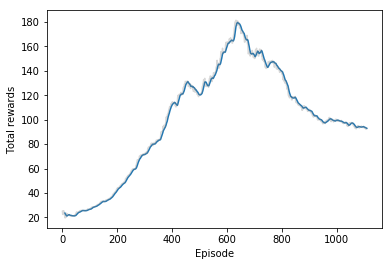

In [23]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

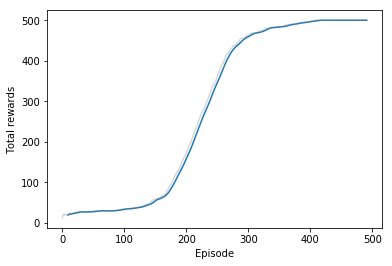

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

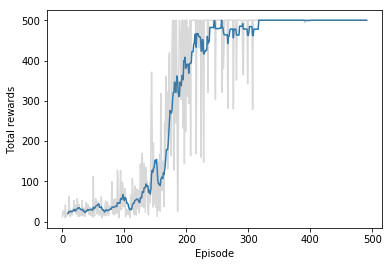

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [65]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [67]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.